In [1]:
!pip install geopy

You should consider upgrading via the 'c:\users\ankitk\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import chain
import pandas as pd
import datetime
import time
import os
import geopy.distance
import math
import sklearn.neighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
def list_slicer (l:list,c1:int,c2:int):
    # slice a non-numpy 2d list from column 1 (c1) to column 2 (c2)
    # return a 2d sublist
    result = []
    for row in l:
        result.append(row[c1:c2])
    return result


def getDateRangeFromWeek(p_year,p_week):
    '''
    # get week start & end date
    # in YYYYMMDD format
    '''
    start = datetime.datetime.strptime(f'{p_year}-W{int(p_week )- 1}-1', "%Y-W%W-%w").date()
    f = start + datetime.timedelta(days=1) # otherwise first day of wk1 is last day of Dec
    l = f + datetime.timedelta(days=6.9)
    firstday = 10000*f.year+100*f.month + f.day
    lastday = 10000*l.year+100*l.month + l.day
    return firstday, lastday

#Call function to get dates range 
firstdate, lastdate =  getDateRangeFromWeek('2013','1')
print('print function ',firstdate,' ', lastdate)

print function  20130101   20130107


## Query by Station

In [4]:
# convert station list to array
# there should be better ways but I didn't find any...
rows, cols = (119503, 9)
Stations= [[0 for i in range(cols)] for j in range(rows)]
with open('ghcnd-stations.txt','r') as f:
    s = f.readlines()
i = 0
for station in s:
    Stations[i][0]=station[:11] #ID
    Stations[i][1]=float(station[12:20]) # Latitude
    Stations[i][2]=float(station[21:30]) # Lontitude
    Stations[i][3]=float(station[31:37]) # Elevatioin
    Stations[i][4]=station[38:40].strip() # state
    Stations[i][5]=station[41:71].strip() # name
    Stations[i][6]=station[72:75].strip() # GSN flag
    Stations[i][7]=station[76:79].strip() # HCN/CRN flag
    WMO = station[80:85].strip()
    if len(WMO)>0:
        Stations[i][8]=int(WMO) # WMO ID
    else:
        Stations[i][8]=""
    i +=1


In [5]:
# Station_df as the station dataframe
my_states = ['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
             'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
             'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ',
             'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD',
             'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
#No Alaska or Hawaii

cols = ["ID","Latitude","Longtitude","Elevation","State","Name","GSN","HCN/CRN","WMO"]
Station_df = pd.DataFrame (Stations, columns = cols)
Station_df.set_index('ID')
Station_df = Station_df[["ID","Latitude","Longtitude","Elevation","State","Name"]]
Station_df = Station_df.query('State==@my_states')
#Station_df.style.set_properties(subset="Name",**{'text-align': 'left'})
Station_df.head()

,ID,Latitude,Longtitude,Elevation,State,Name
52607,US009052008,43.7333,-96.6333,482.0,SD,SIOUX FALLS (ENVIRON. CANADA)
52608,US10RMHS145,40.5268,-105.1113,1569.1,CO,RMHS 1.6 SSW
52609,US10adam001,40.5680,-98.5069,598.0,NE,JUNIATA 1.5 S
52610,US10adam002,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW
52611,US10adam003,40.4663,-98.6537,615.1,NE,HOLSTEIN 0.1 NW


### Parse "by_year" folder to read NOAA data

In [7]:
# open a station file
year = 2003
filename = os.path.join("by_year", str(year) + ".csv")
print(filename)

colnames = ['ID','date','elem','value_2020','M-flag','Q-flag','S-Flag','ObsTime']
df10 = pd.read_csv(filename,names=colnames, header=None)
# df['Date'] = pd.to_datetime(df['YYYYMMDD'].astype(str), format='%Y%m%d')
#display(df.loc[50:60])
df10

by_year\2003.csv


,ID,date,elem,value_2020,M-flag,Q-flag,S-Flag,ObsTime
0,AE000041196,20030101,TMIN,118,NaN,NaN,I,NaN
1,AE000041196,20030101,TAVG,161,H,NaN,S,NaN
2,AEM00041194,20030101,TMIN,126,NaN,NaN,S,NaN
3,AEM00041194,20030101,TAVG,175,H,NaN,S,NaN
4,AEM00041217,20030101,TMAX,238,NaN,NaN,S,NaN
...,...,...,...,...,...,...,...,...
36573752,ZI000067775,20031231,TMAX,312,NaN,NaN,I,NaN
36573753,ZI000067775,20031231,TMIN,158,NaN,NaN,I,NaN
36573754,ZI000067775,20031231,TAVG,248,H,NaN,S,NaN
36573755,ZI000067975,20031231,TMIN,190,NaN,NaN,S,NaN


## Clean the Data Frames

In [8]:
df11 = df10.iloc[:,:4] # remove the flags and obstimes

In [9]:
df11 = df11[["ID","elem","date","value_2020"]] # Reduce comlumns
df11['date'] = pd.to_datetime(df11['date'], format='%Y%m%d') # convert date format

In [10]:
df11['day_of_year'] = df11['date'].dt.dayofyear

In [11]:
df11['wkk'] = (df11['day_of_year']//7)+1

In [12]:
df11 = df11[["ID","elem","wkk","value_2020"]]
df11

,ID,elem,wkk,value_2020
0,AE000041196,TMIN,1,118
1,AE000041196,TAVG,1,161
2,AEM00041194,TMIN,1,126
3,AEM00041194,TAVG,1,175
4,AEM00041217,TMAX,1,238
...,...,...,...,...
36573752,ZI000067775,TMAX,53,312
36573753,ZI000067775,TMIN,53,158
36573754,ZI000067775,TAVG,53,248
36573755,ZI000067975,TMIN,53,190


In [11]:
# weekly data for all stations

df12=df11.groupby(["ID","elem","wkk"]).agg({"value_2020":['sum']})
#df3=df2.groupby(["ID","elem","wkk"])['value'].sum()
df12

value_2020
                            sum
ID          elem wkk           
AE000041196 PRCP 1            5
                 2          364
                 3          114
                 4            8
                 5            0
...                         ...
ZI000067983 TAVG 13         182
            TMAX 10         228
                 13         212
            TMIN 10         145
                 13         166

[5922814 rows x 1 columns]

In [12]:
df13=pd.pivot_table(df12,index = ["ID","elem"],columns="wkk",values = "value_2020")
df13

sum                                                  \
wkk                   1       2       3       4       5       6       7    
ID          elem                                                           
AE000041196 PRCP     5.0   364.0   114.0     8.0     0.0     0.0     0.0   
            TAVG  1300.0  1305.0  1227.0  1327.0  1238.0  1389.0  1324.0   
            TMAX     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
            TMIN   636.0   634.0   423.0   544.0   733.0   809.0   442.0   
AEM00041194 PRCP     0.0   945.0   155.0    20.0     0.0     0.0     0.0   
...                  ...     ...     ...     ...     ...     ...     ...   
ZI000067975 TMIN     NaN     NaN   190.0   172.0     NaN     NaN     NaN   
ZI000067983 PRCP     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
            TAVG     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
            TMAX     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
            TMIN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                                          ...                                  \
wkk                   8       9       10  ...      44      45      46      47   
ID          elem                          ...                                   
AE000041196 PRCP     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
            TAVG  1587.0  1565.0  1500.0  ...  1876.0  1923.0  1956.0  1886.0   
            TMAX     NaN     NaN     NaN  ...  2133.0  2056.0  2073.0  1944.0   
            TMIN   763.0   683.0   780.0  ...  1123.0  1459.0  1532.0  1246.0   
AEM00041194 PRCP     0.0     0.0     0.0  ...     0.0     5.0     0.0     0.0   
...                  ...     ...     ...  ...     ...     ...     ...     ...   
ZI000067975 TMIN     NaN     NaN   155.0  ...     NaN     NaN     NaN     NaN   
ZI000067983 PRCP     NaN     NaN    10.0  ...     NaN     NaN     NaN     NaN   
            TAVG     NaN     NaN   181.0  ...     NaN     NaN     NaN     NaN   
            TMAX     NaN     NaN   228.0  ...     NaN     NaN     NaN     NaN   
            TMIN     NaN     NaN   145.0  ...     NaN     NaN     NaN     NaN   

                                                                 
wkk                   48      49      50      51      52     53  
ID          elem                                                 
AE000041196 PRCP     0.0     0.0    61.0     0.0     0.0    0.0  
            TAVG  1752.0  1786.0  1595.0  1589.0  1508.0  633.0  
            TMAX  1869.0  2219.0  1389.0  1733.0  1349.0  849.0  
            TMIN   750.0   997.0   492.0   836.0   894.0  285.0  
AEM00041194 PRCP     0.0     0.0     0.0     0.0     0.0    0.0  
...                  ...     ...     ...     ...     ...    ...  
ZI000067975 TMIN     NaN     NaN     NaN     NaN     NaN    NaN  
ZI000067983 PRCP     NaN     NaN     NaN     NaN     NaN    NaN  
            TAVG     NaN     NaN     NaN     NaN     NaN    NaN  
            TMAX     NaN     NaN     NaN     NaN     NaN    NaN  
            TMIN     NaN     NaN     NaN     NaN     NaN    NaN  

[182102 rows x 53 columns]

In [13]:
df_PRECIP = df13.query('elem=="PRCP"')
df_PRECIP

sum                                                       \
wkk                  1       2      3       4     5    6      7     8     9    
ID          elem                                                               
AE000041196 PRCP    5.0   364.0  114.0     8.0   0.0  0.0    0.0   0.0   0.0   
AEM00041194 PRCP    0.0   945.0  155.0    20.0   0.0  0.0    0.0   0.0   0.0   
AEM00041217 PRCP    NaN   559.0    NaN     NaN   NaN  NaN    NaN   NaN   NaN   
AEM00041218 PRCP    NaN  1151.0    NaN     NaN   NaN  NaN    NaN   NaN   NaN   
AFM00040938 PRCP  219.0   140.0   51.0  1437.0  53.0  0.0  257.0   NaN  15.0   
...                 ...     ...    ...     ...   ...  ...    ...   ...   ...   
WZ004455110 PRCP    NaN   191.0  140.0     6.0   NaN  NaN  150.0  41.0   NaN   
ZA000067743 PRCP    NaN     NaN    NaN     NaN   NaN  NaN    NaN   NaN   NaN   
ZI000067775 PRCP    NaN     0.0    NaN     NaN   NaN  NaN    NaN   NaN   NaN   
ZI000067975 PRCP    NaN     NaN   10.0     NaN   NaN  NaN    NaN   NaN   NaN   
ZI000067983 PRCP    NaN     NaN    NaN     NaN   NaN  NaN    NaN   NaN   NaN   

                        ...                                                   \
wkk                 10  ...   44   45    46     47    48     49     50    51   
ID          elem        ...                                                    
AE000041196 PRCP   0.0  ...  0.0  0.0   0.0    0.0   0.0    0.0   61.0   0.0   
AEM00041194 PRCP   0.0  ...  0.0  5.0   0.0    0.0   0.0    0.0    0.0   0.0   
AEM00041217 PRCP   NaN  ...  NaN  NaN   NaN    NaN   NaN    NaN    NaN   NaN   
AEM00041218 PRCP   NaN  ...  NaN  NaN   NaN    NaN   NaN    NaN    NaN   NaN   
AFM00040938 PRCP   NaN  ...  0.0  0.0  25.0  244.0  10.0  980.0  319.0  30.0   
...                ...  ...  ...  ...   ...    ...   ...    ...    ...   ...   
WZ004455110 PRCP   NaN  ...  NaN  NaN   NaN    NaN   NaN    NaN    NaN   NaN   
ZA000067743 PRCP  10.0  ...  NaN  NaN   NaN    NaN   NaN    NaN    NaN   NaN   
ZI000067775 PRCP   0.0  ...  NaN  NaN   NaN    NaN   NaN    NaN    NaN   NaN   
ZI000067975 PRCP  30.0  ...  NaN  NaN   NaN    NaN   NaN    NaN    NaN   NaN   
ZI000067983 PRCP  10.0  ...  NaN  NaN   NaN    NaN   NaN    NaN    NaN   NaN   

                                
wkk                   52    53  
ID          elem                
AE000041196 PRCP     0.0   0.0  
AEM00041194 PRCP     0.0   0.0  
AEM00041217 PRCP     NaN   NaN  
AEM00041218 PRCP     NaN   NaN  
AFM00040938 PRCP  1412.0  40.0  
...                  ...   ...  
WZ004455110 PRCP     NaN   NaN  
ZA000067743 PRCP     NaN   NaN  
ZI000067775 PRCP     NaN   NaN  
ZI000067975 PRCP     NaN   NaN  
ZI000067983 PRCP     NaN   NaN  

[39952 rows x 53 columns]

### This looks great, and the unit of precipitation is 1/10th of a mm, however we do have NaN values, so we will first cut all stations with NaNs

In [14]:
X = df_PRECIP.values
X_num = np.nan_to_num(X)

print(X_num)

[[  5. 364. 114. ...   0.   0.   0.]
 [  0. 945. 155. ...   0.   0.   0.]
 [  0. 559.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.  10. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


## Run a KMeans Model

In [15]:
num_clust = 20

kmeans_X = KMeans(n_clusters=num_clust, random_state=0).fit(X_num)
kmeans_labels = kmeans_X.labels_
print(kmeans_labels)

[13 13 13 ... 13 13 13]


In [16]:
cluster_IDs = df_PRECIP.index.tolist()
cluster_IDs_list = []
for i in cluster_IDs:
    j = i[0]
    cluster_IDs_list.append(j)
    
print(cluster_IDs_list)

['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938', 'AFM00040948', 'AFM00040990', 'AG000060390', 'AG000060590', 'AG000060611', 'AGE00147708', 'AGE00147716', 'AGE00147718', 'AGE00147719', 'AGM00060351', 'AGM00060355', 'AGM00060360', 'AGM00060369', 'AGM00060402', 'AGM00060403', 'AGM00060415', 'AGM00060417', 'AGM00060419', 'AGM00060421', 'AGM00060423', 'AGM00060425', 'AGM00060430', 'AGM00060437', 'AGM00060444', 'AGM00060445', 'AGM00060452', 'AGM00060457', 'AGM00060468', 'AGM00060475', 'AGM00060476', 'AGM00060490', 'AGM00060507', 'AGM00060511', 'AGM00060514', 'AGM00060515', 'AGM00060518', 'AGM00060520', 'AGM00060522', 'AGM00060531', 'AGM00060535', 'AGM00060536', 'AGM00060549', 'AGM00060550', 'AGM00060555', 'AGM00060557', 'AGM00060559', 'AGM00060560', 'AGM00060566', 'AGM00060571', 'AGM00060580', 'AGM00060581', 'AGM00060602', 'AGM00060603', 'AGM00060607', 'AGM00060620', 'AGM00060640', 'AGM00060656', 'AGM00060670', 'AGM00060690', 'AJ000037575', 'AJ000037675', 'AJ000037

In [17]:
df_kmeans_labels = pd.DataFrame(list(zip(cluster_IDs_list, kmeans_labels)),
               columns =['ID', 'kmeans_labels'])
df_kmeans_labels.set_index('ID')
df_kmeans_labels.head()

,ID,kmeans_labels
0,AE000041196,13
1,AEM00041194,13
2,AEM00041217,13
3,AEM00041218,13
4,AFM00040938,19


In [18]:
df_final = Station_df.set_index('ID').join(df_kmeans_labels.set_index('ID'))
df_final.head()

,Latitude,Longtitude,Elevation,State,Name,kmeans_labels
ID,,,,,,
US009052008,43.7333,-96.6333,482.0,SD,SIOUX FALLS (ENVIRON. CANADA),NaN
US10RMHS145,40.5268,-105.1113,1569.1,CO,RMHS 1.6 SSW,NaN
US10adam001,40.5680,-98.5069,598.0,NE,JUNIATA 1.5 S,NaN
US10adam002,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW,11.0
US10adam003,40.4663,-98.6537,615.1,NE,HOLSTEIN 0.1 NW,NaN


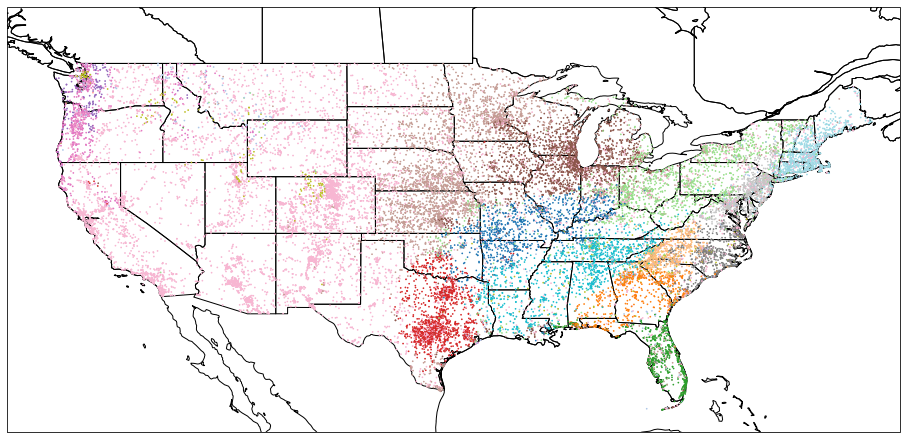

In [19]:
fig = plt.figure(figsize=(16,12))
m_usa = plt.axes(projection=ccrs.PlateCarree())
m_usa.set_extent([-128, -65, 23, 53], ccrs.PlateCarree())
m_usa.add_feature(cfeature.STATES)
m_usa.coastlines()

Lat = df_final["Latitude"].to_numpy()
Long = df_final["Longtitude"].to_numpy()
Labs = df_final["kmeans_labels"].to_numpy()

m_usa.scatter(Long, Lat, transform=ccrs.PlateCarree(), s=0.5, c=Labs, cmap="tab20")

# Lets Look at single clusters, some are more spread out than others

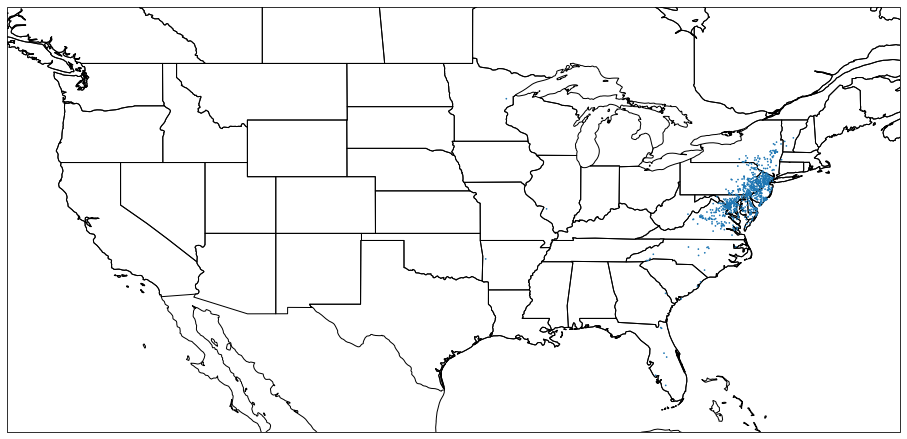

In [20]:
fig = plt.figure(figsize=(16,12))
m_usa = plt.axes(projection=ccrs.PlateCarree())
m_usa.set_extent([-128, -65, 23, 53], ccrs.PlateCarree())
m_usa.add_feature(cfeature.STATES)
m_usa.coastlines()

df_final_1 = df_final.query('kmeans_labels==15')

Lat  = df_final_1["Latitude"].to_numpy()
Long = df_final_1["Longtitude"].to_numpy()
Labs = df_final_1["kmeans_labels"].to_numpy()

m_usa.scatter(Long, Lat, transform=ccrs.PlateCarree(), s=0.5, c=Labs, cmap="tab20")

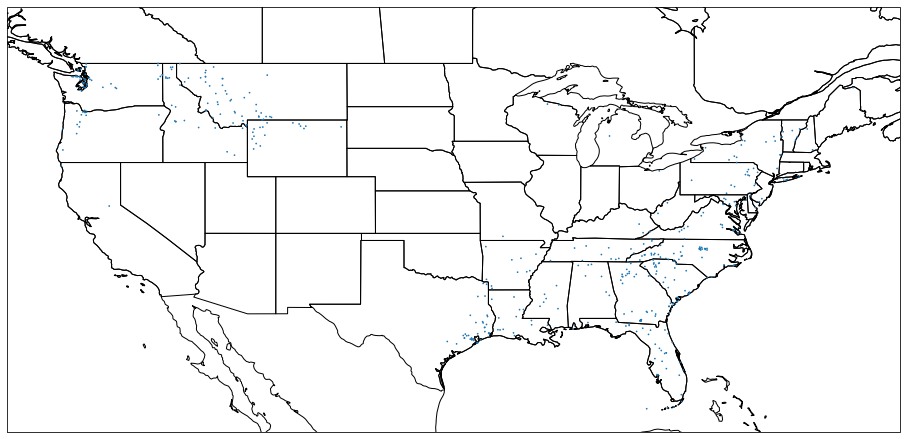

In [21]:
fig = plt.figure(figsize=(16,12))
m_usa = plt.axes(projection=ccrs.PlateCarree())
m_usa.set_extent([-128, -65, 23, 53], ccrs.PlateCarree())
m_usa.add_feature(cfeature.STATES)
m_usa.coastlines()

df_final_2 = df_final.query('kmeans_labels==1')

Lat  = df_final_2["Latitude"].to_numpy()
Long = df_final_2["Longtitude"].to_numpy()
Labs = df_final_2["kmeans_labels"].to_numpy()

m_usa.scatter(Long, Lat, transform=ccrs.PlateCarree(), s=0.5, c=Labs, cmap="tab20")

## Look at just southeast

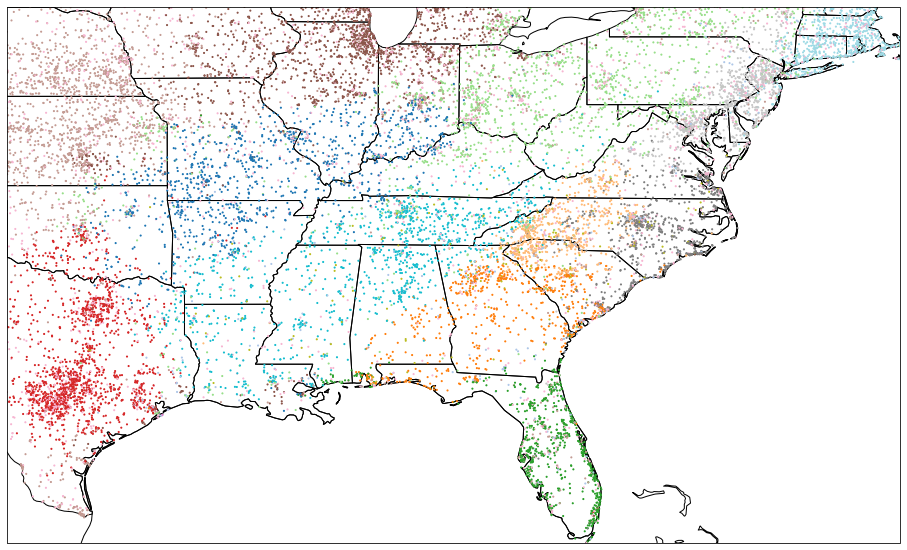

In [22]:
fig = plt.figure(figsize=(16,12))
m_usa = plt.axes(projection=ccrs.PlateCarree())
m_usa.set_extent([-100, -70, 25, 43], ccrs.PlateCarree())
m_usa.add_feature(cfeature.STATES)
m_usa.coastlines()

Lat = df_final["Latitude"].to_numpy()
Long = df_final["Longtitude"].to_numpy()
Labs = df_final["kmeans_labels"].to_numpy()

m_usa.scatter(Long, Lat, transform=ccrs.PlateCarree(), s=1.2, c=Labs, cmap="tab20")

## Lets average our weather vectors by group and plot some of them

In [23]:
df_PRECIP_1 = df_PRECIP.copy()
#df_PRECIP_1 = df_PRECIP_1.reset_index(drop=True, inplace=True)
#df_PRECIP_1.columns = df_PRECIP_1.columns.to_flat_index().str.join('_')
#df_PRECIP_1.rename(columns = {'ID':'stationID'}, inplace = True)
df_PRECIP_1.head()


sum                                                      \
wkk                  1       2      3       4     5    6      7    8     9    
ID          elem                                                              
AE000041196 PRCP    5.0   364.0  114.0     8.0   0.0  0.0    0.0  0.0   0.0   
AEM00041194 PRCP    0.0   945.0  155.0    20.0   0.0  0.0    0.0  0.0   0.0   
AEM00041217 PRCP    NaN   559.0    NaN     NaN   NaN  NaN    NaN  NaN   NaN   
AEM00041218 PRCP    NaN  1151.0    NaN     NaN   NaN  NaN    NaN  NaN   NaN   
AFM00040938 PRCP  219.0   140.0   51.0  1437.0  53.0  0.0  257.0  NaN  15.0   

                       ...                                                   \
wkk                10  ...   44   45    46     47    48     49     50    51   
ID          elem       ...                                                    
AE000041196 PRCP  0.0  ...  0.0  0.0   0.0    0.0   0.0    0.0   61.0   0.0   
AEM00041194 PRCP  0.0  ...  0.0  5.0   0.0    0.0   0.0    0.0    0.0   0.0   
AEM00041217 PRCP  NaN  ...  NaN  NaN   NaN    NaN   NaN    NaN    NaN   NaN   
AEM00041218 PRCP  NaN  ...  NaN  NaN   NaN    NaN   NaN    NaN    NaN   NaN   
AFM00040938 PRCP  NaN  ...  0.0  0.0  25.0  244.0  10.0  980.0  319.0  30.0   

                                
wkk                   52    53  
ID          elem                
AE000041196 PRCP     0.0   0.0  
AEM00041194 PRCP     0.0   0.0  
AEM00041217 PRCP     NaN   NaN  
AEM00041218 PRCP     NaN   NaN  
AFM00040938 PRCP  1412.0  40.0  

[5 rows x 53 columns]

In [24]:
df_final_all = df_final.join(df_PRECIP)
df_final_all.reset_index(inplace=True)

df_final_all.head()

C:\Users\Trent\AppData\Local\Temp\ipykernel_12316\3035338495.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_final_all = df_final.join(df_PRECIP)


,ID,elem,Latitude,Longtitude,Elevation,State,Name,kmeans_labels,"(sum, 1)","(sum, 2)",...,"(sum, 44)","(sum, 45)","(sum, 46)","(sum, 47)","(sum, 48)","(sum, 49)","(sum, 50)","(sum, 51)","(sum, 52)","(sum, 53)"
0,US10adam002,PRCP,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW,11.0,0.0,3.0,...,5.0,10.0,272.0,0.0,38.0,0.0,0.0,46.0,8.0,25.0
1,US10adam004,PRCP,40.4798,-98.4026,570.0,NE,AYR 3.5 NE,11.0,0.0,3.0,...,0.0,18.0,292.0,0.0,66.0,0.0,66.0,36.0,18.0,89.0
2,US10adam008,PRCP,40.4953,-98.2973,566.9,NE,GLENVIL 2.3 WSW,11.0,0.0,0.0,...,0.0,13.0,297.0,0.0,49.0,0.0,48.0,23.0,58.0,0.0
3,US10adam010,PRCP,40.5532,-98.6297,622.1,NE,JUNIATA 6.9 WSW,11.0,0.0,0.0,...,0.0,71.0,137.0,0.0,63.0,0.0,64.0,0.0,10.0,31.0
4,US10adam015,PRCP,40.6258,-98.7034,632.2,NE,KENESAW 2.4 W,11.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_final_all = df_final_all.set_axis(["ID", "elem", "Latitude", "Longtitude", "Elevation", "State", "Name", 
                                        "kmeans_labels", 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 
                                        'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 
                                        'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 
                                        'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 
                                        'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 
                                        'P50', 'P51', 'P52', 'P53'], axis=1, inplace=False)

df_final_all

,ID,elem,Latitude,Longtitude,Elevation,State,Name,kmeans_labels,P1,P2,...,P44,P45,P46,P47,P48,P49,P50,P51,P52,P53
0,US10adam002,PRCP,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW,11.0,0.0,3.0,...,5.0,10.0,272.0,0.0,38.0,0.0,0.0,46.0,8.0,25.0
1,US10adam004,PRCP,40.4798,-98.4026,570.0,NE,AYR 3.5 NE,11.0,0.0,3.0,...,0.0,18.0,292.0,0.0,66.0,0.0,66.0,36.0,18.0,89.0
2,US10adam008,PRCP,40.4953,-98.2973,566.9,NE,GLENVIL 2.3 WSW,11.0,0.0,0.0,...,0.0,13.0,297.0,0.0,49.0,0.0,48.0,23.0,58.0,0.0
3,US10adam010,PRCP,40.5532,-98.6297,622.1,NE,JUNIATA 6.9 WSW,11.0,0.0,0.0,...,0.0,71.0,137.0,0.0,63.0,0.0,64.0,0.0,10.0,31.0
4,US10adam015,PRCP,40.6258,-98.7034,632.2,NE,KENESAW 2.4 W,11.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28022,USW00094992,PRCP,47.7472,-90.3444,185.9,MN,GRAND MARAIS,11.0,32.0,46.0,...,41.0,130.0,137.0,28.0,57.0,0.0,13.0,53.0,174.0,41.0
28023,USW00094993,PRCP,45.6689,-96.9914,353.9,SD,SISSETON MUNI AP,13.0,61.0,8.0,...,3.0,74.0,0.0,48.0,3.0,0.0,0.0,3.0,41.0,71.0
28024,USW00094994,PRCP,43.1561,-90.6775,204.8,WI,BOSCOBEL AP,10.0,13.0,33.0,...,0.0,0.0,395.0,0.0,71.0,0.0,46.0,0.0,23.0,61.0
28025,USW00094995,PRCP,40.8483,-96.5650,362.4,NE,LINCOLN 8 ENE,11.0,0.0,33.0,...,0.0,32.0,199.0,38.0,79.0,0.0,178.0,0.0,34.0,196.0


In [26]:
col_names = ["cluster_num"]
for i in range(1, 54):
    col_names.append(str("P" + str(i)))
    
df_avg = pd.DataFrame(columns = col_names)
df_avg

,cluster_num,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P44,P45,P46,P47,P48,P49,P50,P51,P52,P53


In [27]:
"""for j in range(1, num_clust+1): #iterate over clusters
    #daily_avg = [str("cluster_" + str(j))]
    daily_dict = {"cluster_num": str("cluster_" + str(j))}
    
    for i in range(1, 54):  #iterate over days
        val = str("P" + str(i))  #Name of day col
        float_j = float(j)
        
        day_avg = df_final_all.loc[df_final_all['kmeans_labels'] == float_j, val].mean()
        #daily_avg.append(day_avg)
        daily_dict[val] = day_avg
    #print(daily_dict)
    df_avg = df_avg.append(daily_dict, ignore_index=True)
df_avg
"""

'for j in range(1, num_clust+1): #iterate over clusters\n    #daily_avg = [str("cluster_" + str(j))]\n    daily_dict = {"cluster_num": str("cluster_" + str(j))}\n    \n    for i in range(1, 54):  #iterate over days\n        val = str("P" + str(i))  #Name of day col\n        float_j = float(j)\n        \n        day_avg = df_final_all.loc[df_final_all[\'kmeans_labels\'] == float_j, val].mean()\n        #daily_avg.append(day_avg)\n        daily_dict[val] = day_avg\n    #print(daily_dict)\n    df_avg = df_avg.append(daily_dict, ignore_index=True)\ndf_avg\n'

In [28]:
for j in range(1, num_clust+1): #iterate over clusters
    daily_avg = [str("cluster_" + str(j))]
    #daily_dict = {"cluster_num": str("cluster_" + str(j))}
    
    for i in range(1, 54):  #iterate over days
        val = str("P" + str(i))  #Name of day col
        float_j = float(j)
        
        day_avg = df_final_all.loc[df_final_all['kmeans_labels'] == float_j, val].mean()
        daily_avg.append(day_avg)

        #daily_dict[val].append(day_avg)
        
    df_avg.loc[len(df_avg)] = daily_avg
df_avg

,cluster_num,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P44,P45,P46,P47,P48,P49,P50,P51,P52,P53
0,cluster_1,181.592105,222.805195,129.755365,170.253275,148.791304,266.165957,172.687500,125.435146,111.143460,...,234.066038,99.095588,343.635266,106.495074,254.351942,139.377451,149.460048,282.695545,225.120000,76.208995
1,cluster_2,349.045886,351.400000,284.634069,161.254808,157.547619,728.266771,366.710031,600.384735,274.706977,...,196.535937,26.258170,321.251543,4.659966,503.432558,103.354134,75.458268,195.390358,289.333868,22.580968
2,cluster_3,356.856083,408.542097,233.292035,334.777448,112.229851,1105.914956,461.893016,182.211310,197.019202,...,528.384615,1.701131,818.804985,8.404187,410.703593,206.573152,209.897126,264.512977,291.814642,17.437398
3,cluster_4,105.919877,34.636511,33.206731,70.445860,163.170245,208.150456,146.412308,58.384496,178.203927,...,230.125894,366.730435,655.059829,147.411852,96.773071,186.617084,39.341945,196.384956,117.351271,5.906902
4,cluster_5,163.735053,282.412166,184.527673,199.547074,48.225064,326.814908,187.830177,72.616508,193.524703,...,389.680653,10.526090,249.720235,120.729552,220.085221,160.114008,91.573333,160.867692,237.141264,110.274921
5,cluster_6,21.808973,208.891927,235.652286,172.841495,105.307943,66.374749,346.430307,159.459512,8.596012,...,130.628608,0.825555,9.527553,14.611193,328.311069,47.515234,110.166122,99.864741,8.352018,312.035256
6,cluster_7,710.333333,1007.333333,431.666667,643.000000,626.000000,2997.333333,499.333333,135.000000,211.333333,...,84.000000,406.000000,787.000000,177.666667,313.000000,67.333333,237.000000,838.666667,203.000000,406.333333
7,cluster_8,1513.907143,1612.630435,614.071942,1651.928571,1384.357143,1448.407143,542.692857,280.302158,312.669065,...,104.050000,912.371429,1359.107143,802.121429,504.835714,100.864286,571.242857,1682.121429,515.914286,545.666667
8,cluster_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,cluster_10,24.681789,310.945155,162.888680,133.561037,18.903205,88.872518,59.538212,78.749840,67.464240,...,52.200319,4.177815,266.360187,46.414847,213.999461,12.591918,197.194798,16.288273,48.573418,126.099470


In [29]:
vals_list = df_avg.values.tolist()
print(vals_list[0][0:54])
#print(display(df_avg.iloc[[1]]).values.tolist())


['cluster_1', 181.5921052631579, 222.80519480519482, 129.75536480686696, 170.25327510917032, 148.7913043478261, 266.16595744680853, 172.6875, 125.43514644351464, 111.14345991561181, 196.5966386554622, 118.57758620689656, 77.92916666666666, 131.16309012875536, 173.068669527897, 118.15948275862068, 162.4734693877551, 189.1726907630522, 236.81923076923076, 99.27131782945736, 191.911877394636, 237.36398467432952, 172.74125874125875, 190.57439446366783, 201.7123745819398, 160.2135593220339, 234.56730769230768, 166.27243589743588, 145.527950310559, 55.845425867507885, 185.32628398791542, 148.71468926553672, 170.21428571428572, 197.3684210526316, 194.60367454068242, 211.04314720812184, 136.92695214105794, 145.8074074074074, 224.25179856115108, 399.37557603686633, 161.72727272727272, 344.58236658932714, 164.00236406619385, 194.40749414519905, 234.06603773584905, 99.09558823529412, 343.6352657004831, 106.49507389162562, 254.35194174757282, 139.37745098039215, 149.4600484261501, 282.695544554455

#### We will plot all groups' average rainfall per day

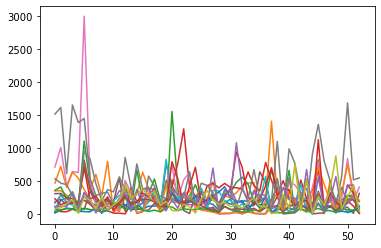

In [30]:
fig = plt.figure()

for clust in range(num_clust):
    clust_key = vals_list[clust][0]
    plt.plot(vals_list[clust][1:54], label=clust_key)
    
    
plt.show()

## Let's unpack this and plot a single cluster on the map and its corresponding average rainfall

Text(0.5, 1.0, 'Rainfall per week of the year')

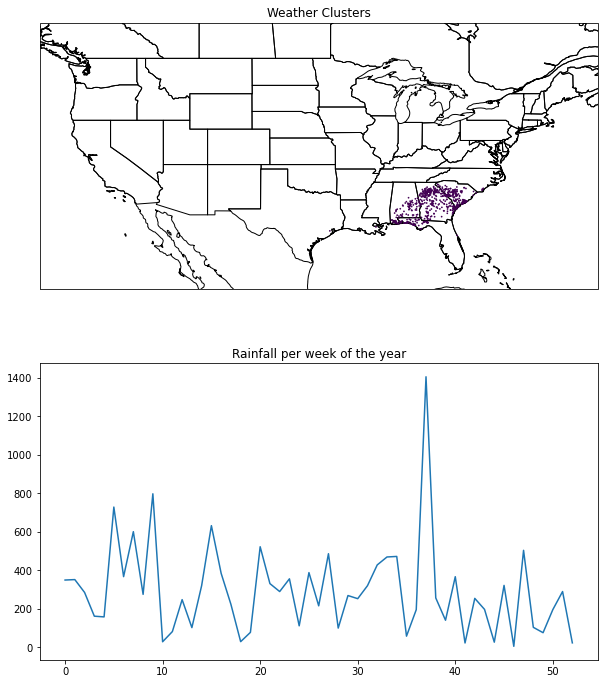

In [31]:
# testing 2 plots above each other
plt.figure(figsize=(10,12))
plt.tight_layout()

# 1st subplot: cluster data on map
top_plot = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())

top_plot.set_extent([-128, -65, 23, 53], ccrs.PlateCarree())
top_plot.add_feature(cfeature.STATES)
top_plot.coastlines()
top_plot.set_title("Weather Clusters")


df_final_1 = df_final.query('kmeans_labels==2')

Lat  = df_final_1["Latitude"].to_numpy()
Long = df_final_1["Longtitude"].to_numpy()
Labs = df_final_1["kmeans_labels"].to_numpy()

top_plot.scatter(Long, Lat, transform=ccrs.PlateCarree(), s=0.5, c=Labs)

# 2nd subplot: ... to be conintued (example data for now)
bot_plot = plt.subplot(2, 1, 2)
bot_plot.plot(vals_list[1][1:54], label=clust_key)
bot_plot.set_title("Rainfall per week of the year")